>
> # MaaSSim tutorial
>
> ## Results
>
-----

Run the Exec simulation with 'config.json' parameterisation and parse the results


import simulator

In [1]:
import os, sys
import pandas as pd
import logging
from dotmap import DotMap
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from MaaSSim.utils import get_config, load_G, prep_supply_and_demand  # simulator
from MaaSSim.data_structures import structures as inData
from MaaSSim.simulators import simulate, simulate_parallel
from MaaSSim.traveller import travellerEvent
from MaaSSim.driver import driverEvent

In [3]:
params = get_config('../../data/config/default.json')  # load configuration

## simulation

In [4]:
params.simTime = 2 # 1 hour of simulation
params.nP = 50 # reuqests (and passengers)
params.nV = 30 # vehicles

In [5]:
sim = simulate(params = params, logger_level = logging.WARNING)

15-10-20 12:36:49-WARNING-Setting up 2h simulation at 2020-10-15 11:37:53 for 30 vehicles and 50 passengers in Nootdorp, Netherlands
15-10-20 12:36:51-WARNING-simulation time 1.7 s
15-10-20 12:36:51-WARNING-assertion tests for simulation results - passed


## results

traveller results

In [6]:
sim.res[0].pax_exp[['TRAVEL','WAIT','OPERATIONS']].sample(5)

,TRAVEL,WAIT,OPERATIONS
pax,,,
23,66.0,0.0,55.0
30,119.0,56.0,55.0
19,29.0,112.0,55.0
42,195.0,18.0,55.0
45,186.0,0.0,55.0


driver results

In [7]:
sim.res[0].veh_exp[['TRAVEL','WAIT','OPERATIONS','IDLE', 'PAX_KM', 'REVENUE']].sample(5)

,TRAVEL,WAIT,OPERATIONS,IDLE,PAX_KM,REVENUE
veh,,,,,,
30,244.0,0,65.0,10998.0,2.440,2.440
6,192.0,0,130.0,9562.0,1.928,1.928
3,335.0,0,112.0,7225.0,3.355,3.355
9,233.0,0,130.0,8248.0,2.336,2.336
24,391.0,0,195.0,9074.0,3.920,3.920


In [7]:
trip_id  = 3 # we inspext traveller 3
req = sim.inData.requests[sim.inData.requests.pax_id==trip_id].squeeze() # this is his ride request
aggr = sim.res[0].pax_exp.loc[trip_id] # this is his aggregated results 
raw = sim.runs[0].trips[sim.runs[0].trips.pax == trip_id]  # this is his record within simulation

In [8]:
req.to_frame().T

,pax_id,origin,destination,treq,tdep,ttrav,tarr,tdrop,shareable,schedule_id,dist,ride_id,position,sim_schedule
3,3,44986749,44974249,2020-10-13 09:42:45,NaN,00:01:47,2020-10-13 09:44:32,NaN,False,NaN,1077,3,0,node time req_id od 0 NaN...


/Users/rkucharski/Documents/GitHub/MaaSSim/MaaSSim/visualizations.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['status_num'] = df.apply(lambda x: travellerEvent[x.event].value, axis=1)


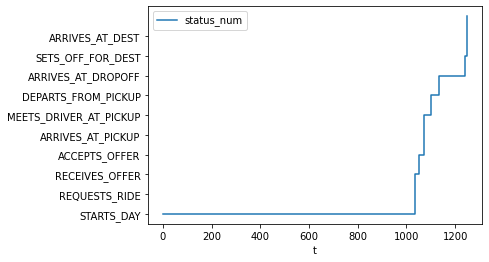

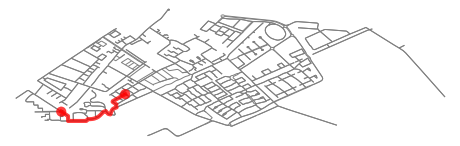

In [9]:
sim.plot_trip(trip_id)

In [10]:
print('request time:')
print(req.treq)
print('simulated request time:')
print(sim.t0+pd.to_timedelta(raw[raw.event == travellerEvent.REQUESTS_RIDE.name].squeeze().t,'s'))

request time:
2020-10-13 09:42:45
simulated request time:
2020-10-13 09:42:45


In [11]:
print('travel time at request level:')
print(req.ttrav) 
print('simulated travel time:')
print(pd.to_timedelta(raw[raw.event == travellerEvent.ARRIVES_AT_DROPOFF.name].squeeze().t -  raw[raw.event == travellerEvent.DEPARTS_FROM_PICKUP.name].squeeze().t,'s'))
print('delay:')
print(pd.to_timedelta(raw[raw.event == travellerEvent.ARRIVES_AT_DROPOFF.name].squeeze().t -  raw[raw.event == travellerEvent.DEPARTS_FROM_PICKUP.name].squeeze().t,'s')-req.ttrav)

travel time at request level:
0 days 00:01:47
simulated travel time:
0 days 00:01:47
delay:
0 days 00:00:00


In [12]:
print('lost time before')
pd.to_timedelta(raw[raw.event == travellerEvent.DEPARTS_FROM_PICKUP.name].squeeze().t -  raw[raw.event == travellerEvent.REQUESTS_RIDE.name].squeeze().t,'s')

lost time before


Timedelta('0 days 00:01:36')

In [13]:
print('lost time after')
pd.to_timedelta(raw[raw.event == travellerEvent.ARRIVES_AT_DEST.name].squeeze().t -  raw[raw.event == travellerEvent.ARRIVES_AT_DROPOFF.name].squeeze().t,'s')

lost time after


Timedelta('0 days 00:00:10')

In [14]:
print('total time since request')
pd.to_timedelta(raw[raw.event == travellerEvent.ARRIVES_AT_DEST.name].squeeze().t -  raw[raw.event == travellerEvent.REQUESTS_RIDE.name].squeeze().t,'s')

total time since request


Timedelta('0 days 00:03:33')

In [15]:
raw['duration'] = raw.t.diff().apply(lambda x: pd.to_timedelta(x,'s'))
raw

/Users/rkucharski/anaconda3/envs/maassim/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,pax,pos,t,event,veh_id,duration
0,3,44986749,0,STARTS_DAY,NaN,NaT
1,3,44986749,1036,REQUESTS_RIDE,NaN,00:17:16
2,3,44986749,1036,RECEIVES_OFFER,NaN,00:00:00
3,3,44986749,1051,ACCEPTS_OFFER,NaN,00:00:15
4,3,44986749,1071,ARRIVES_AT_PICKUP,2.0,00:00:20
5,3,44986749,1102,MEETS_DRIVER_AT_PICKUP,2.0,00:00:31
6,3,44986749,1132,DEPARTS_FROM_PICKUP,2.0,00:00:30
7,3,44974249,1239,ARRIVES_AT_DROPOFF,2.0,00:01:47
8,3,44974249,1249,SETS_OFF_FOR_DEST,NaN,00:00:10
9,3,44974249,1249,ARRIVES_AT_DEST,NaN,00:00:00


# Interpretation of _aggr_


In [16]:
params.times

DotMap(request=15, transaction=20, pickup=30, dropoff=10, patience=600, pickup_patience=90)

In [17]:
print('before request')
print(pd.to_timedelta(aggr.REQUESTS_RIDE,'s'))

before request
0 days 00:17:16


In [18]:
print('waiting for match')
print(pd.to_timedelta(aggr.RECEIVES_OFFER,'s'))

waiting for match
0 days 00:00:00


In [19]:
print('walk to origin')
print(pd.to_timedelta(aggr.ARRIVES_AT_PICKUP,'s'))

walk to origin
0 days 00:00:20


In [20]:
print('waiting time at origin (for vehicle)')
print(pd.to_timedelta(aggr.MEETS_DRIVER_AT_PICKUP,'s'))

waiting time at origin (for vehicle)
0 days 00:00:31


In [21]:
print('starting (in the vehicle before depart)')
print(pd.to_timedelta(aggr.DEPARTS_FROM_PICKUP,'s'))

starting (in the vehicle before depart)
0 days 00:00:30


In [22]:
print('travel time')
print(pd.to_timedelta(aggr.ARRIVES_AT_DROPOFF,'s'))

travel time
0 days 00:01:47


In [23]:
print('leaving the vehicle')
print(pd.to_timedelta(aggr.SETS_OFF_FOR_DEST,'s'))

leaving the vehicle
0 days 00:00:10


In [24]:
print('time to dest (from dropoff)')
print(pd.to_timedelta(aggr.ARRIVES_AT_DEST,'s'))

time to dest (from dropoff)
0 days 00:00:00


In [25]:
aggr.apply(lambda x: pd.to_timedelta(x,'s')).sort_values().to_frame()

,3
STARTS_DAY,00:00:00
RECEIVES_OFFER,00:00:00
IS_REJECTED_BY_VEHICLE,00:00:00
REJECTS_OFFER,00:00:00
ARRIVES_AT_DEST,00:00:00
PREFERS_OTHER_SERVICE,00:00:00
LOSES_PATIENCE,00:00:00
SETS_OFF_FOR_DEST,00:00:10
ACCEPTS_OFFER,00:00:15
ARRIVES_AT_PICKUP,00:00:20


-------------
Rafal Kucharski, 2020, Delft, r.m.kucharski@tudelft.nl